In [1]:
!pip install -q --upgrade transformers diffusers ftfy

     |████████████████████████████████| 5.8 MB 4.3 MB/s 
     |████████████████████████████████| 503 kB 73.8 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 7.6 MB 64.3 MB/s 
     |████████████████████████████████| 182 kB 68.5 MB/s 


In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

from IPython.display import HTML
from base64 import b64encode

logging.set_verbosity_error()

torch_device = "cuda" if torch.cuda.is_available () else "cpu"

In [4]:
#Load the autoencoder model which will be used to decode the latents into image space
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

#Load the tokenize and text encoder to tokenize and encode text
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

#the UNet model for generating latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder = "unet")

#noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

#using GPU
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

0it [00:00, ?it/s]

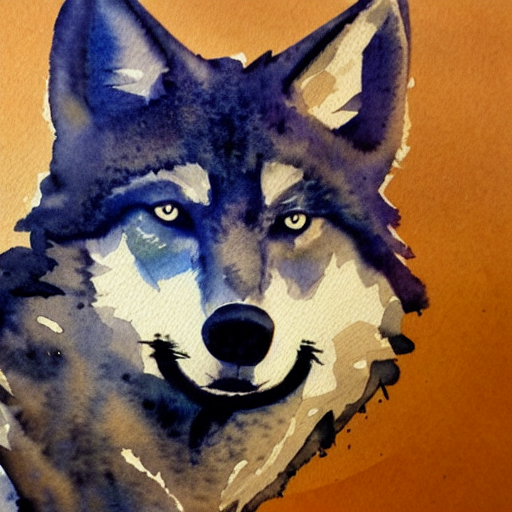

In [5]:
#settings
prompt = ["a watercolor painting of a wolf"]
height = 512
width = 512
num_inference_steps = 30
guidance_scale = 7.5
generator = torch.manual_seed(32)
batch_size = 1

#text preparation
text_input = tokenizer(prompt, padding = "max_length", max_length=tokenizer.model_max_length, truncation = True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_langth = max_length, return_tensors = "pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

#schduler preparation
scheduler.set_timesteps(num_inference_steps)

#latents preparation
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator = generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma #scaling

#loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes
    latent_model_input = torch.cat([latents]*2)
    sigma = scheduler.sigmas[i]
    #scale the latents (preconditioning)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    #predict the noise residual 
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states = text_embeddings).sample
    
    #performance guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

#scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
  image = vae.decode(latents).sample

#Display
image = (image / 2 + 0.5).clamp(0,1)
image = image.detach().cpu().permute(0,2,3,1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [6]:
#Autoencoder
def pil_to_latent(input_im):
  #single image -> single latent in a batch (sizes 1, 4, 64, 64)
  with torch.no_grad():
    latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) #note scaling
  return 0.18215 * latent.latent_dist.sample()


def latents_to_pil(latents):
  #batch of latents -> list of images
  latents = (1/0.18215) * latents
  with torch.no_grad():
    image = vae.decode(latents).sample
  image = (image / 2 + 0.5).clamp(0,1)
  image = image.detach().cpu().permute(0,2,3,1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

In [7]:
path = '/content/drive/MyDrive/head.jpg'

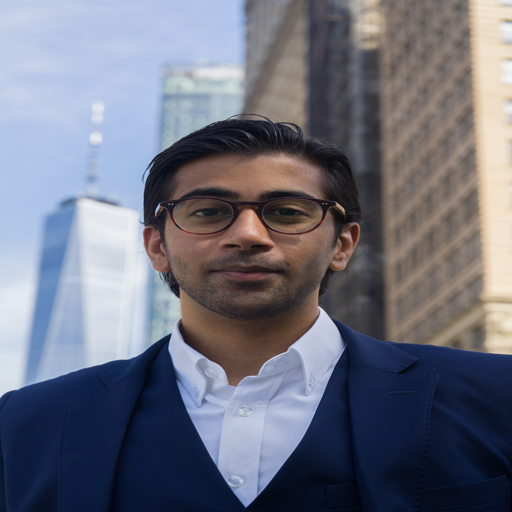

In [8]:
input_image = Image.open(path).resize((512,512))
input_image

In [9]:
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

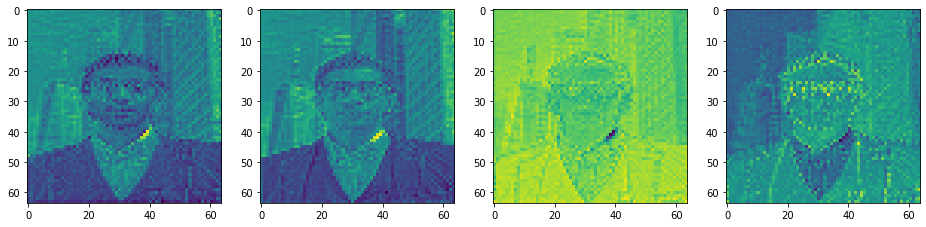

In [10]:
fig, axs = plt.subplots(1,4, figsize=(16, 4))
for c in range(4):
  axs[c].imshow(encoded[0][c].cpu())

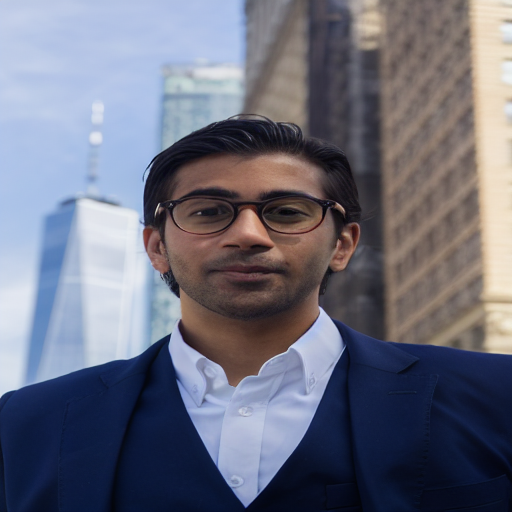

In [11]:
decoded = latents_to_pil(encoded)[0]
decoded

In [12]:
#setting the number of sampling steps:
scheduler.set_timesteps(15)

In [13]:
print(scheduler.timesteps)

tensor([999.0000, 927.6429, 856.2857, 784.9286, 713.5714, 642.2143, 570.8571,
        499.5000, 428.1429, 356.7857, 285.4286, 214.0714, 142.7143,  71.3571,
          0.0000], dtype=torch.float64)


In [14]:
#view equivalent noise levels
print(scheduler.sigmas)

tensor([14.6146,  9.6826,  6.6780,  4.7746,  3.5221,  2.6666,  2.0606,  1.6156,
         1.2768,  1.0097,  0.7913,  0.6056,  0.4397,  0.2780,  0.0292,  0.0000])


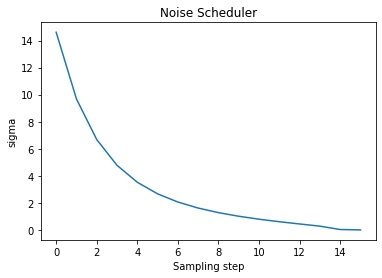

In [15]:
plt.plot(scheduler.sigmas)
plt.title('Noise Scheduler')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

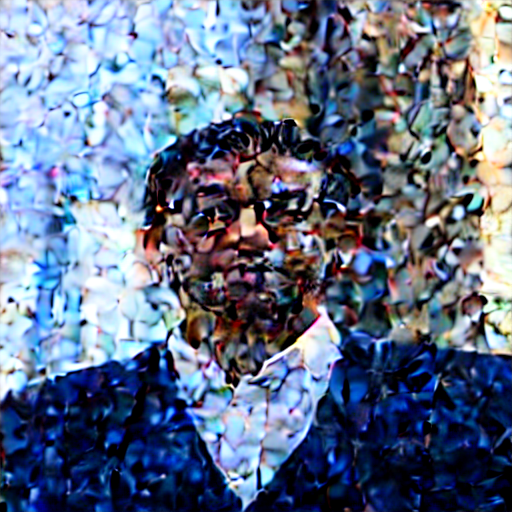

In [16]:
noise = torch.randn_like(encoded) #random noise
timestep = 10 # equivalent to step 10 our of 15 in scheduler above
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps = torch.tensor([scheduler.timesteps[timestep]]))
latents_to_pil(encoded_and_noised.float())[0] #display

0it [00:00, ?it/s]

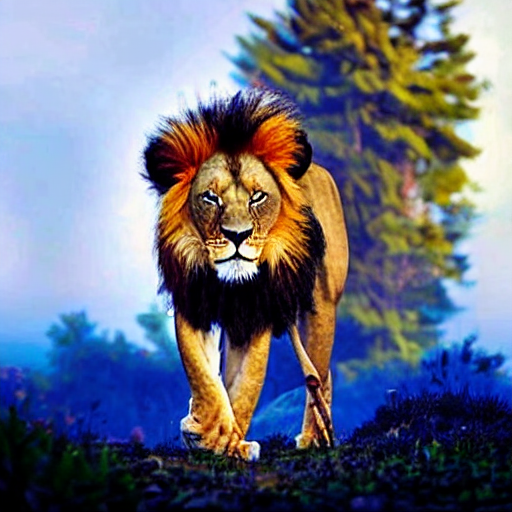

In [17]:
# settings (same as before but new prompt)
prompt = ["A colorful lion, nat geo photo"]
height = 512
width = 512
num_inference_steps = 50
guidance_scale = 8
generator = torch.manual_seed(32)
batch_size = 1

text_input = tokenizer(prompt, padding = "max_length", max_length=tokenizer.model_max_length, truncation = True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_langth = max_length, return_tensors = "pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

#scheduler preparation - setting the number of inference steps
scheduler.set_timesteps(num_inference_steps)

#latents preparation - noising appropriately for start_step
start_step = 10
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps = torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to(torch_device).float()

#loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
  if i > start_step: # this is the only modification to the loop done
    #expand the latents if we are doing classifier-free guidance to avoid doing two forward passes
    latent_model_input = torch.cat([latents]*2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    #predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
    
    #perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

latents_to_pil(latents)[0]

In [18]:
text = 'A picture of a wolf'

In [19]:
#turn text into a sequence of tokens
text_in = tokenizer(text, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_in['input_ids'][0]

tensor([49406,   320,  1674,   539,   320,  5916, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [20]:
#see individual tokens
for t in text_in['input_ids'][0][:8]:
  print(t, tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(1674) picture</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(5916) wolf</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


In [21]:
#grab output embeddings
output_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
print('Shape:', output_embeddings.shape)
output_embeddings

Shape: torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [-1.3946, -1.0500, -0.5963,  ..., -0.4677, -0.4711,  2.0452],
         ...,
         [-0.8167,  1.4171,  0.6626,  ..., -0.8436, -0.8735,  1.1069],
         [-0.8097,  1.3849,  0.6471,  ..., -0.8094, -0.8613,  1.0719],
         [-0.8495,  1.5009,  0.6638,  ..., -0.8856, -0.7457,  1.0345]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [22]:
text_encoder.text_model.embeddings

CLIPTextEmbeddings(
  (token_embedding): Embedding(49408, 768)
  (position_embedding): Embedding(77, 768)
)

In [23]:
#Access embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_emb_layer #vocab size

Embedding(49408, 768)

In [24]:
#embed a token - in this case the one for "wolf"
embedding = token_emb_layer(torch.tensor(5916, device=torch_device))
embedding.shape

torch.Size([768])

In [25]:
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))
print(token_embeddings.shape) #batch size 1, 77 tokens, 768 values for each
token_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0011,  0.0032,  0.0003,  ..., -0.0018,  0.0003,  0.0019],
         [ 0.0013, -0.0011, -0.0126,  ..., -0.0124,  0.0120,  0.0080],
         [ 0.0021, -0.0087,  0.0013,  ..., -0.0045,  0.0042, -0.0061],
         ...,
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [26]:
#positional embeddings tell model where the token is in the sequence
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 768)

In [27]:
position_ids= text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)
position_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0016,  0.0020,  0.0002,  ..., -0.0013,  0.0008,  0.0015],
         [ 0.0042,  0.0029,  0.0002,  ...,  0.0010,  0.0015, -0.0012],
         [ 0.0018,  0.0007, -0.0012,  ..., -0.0029, -0.0009,  0.0026],
         ...,
         [ 0.0216,  0.0055, -0.0101,  ..., -0.0065, -0.0029,  0.0037],
         [ 0.0188,  0.0073, -0.0077,  ..., -0.0025, -0.0009,  0.0057],
         [ 0.0330,  0.0281,  0.0289,  ...,  0.0160,  0.0102, -0.0310]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [28]:
#combining the token and position embeddings to feed as final input into transformer model
input_embeddings = token_embeddings + position_embeddings
print(input_embeddings.shape)
input_embeddings

torch.Size([1, 77, 768])


tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 3.9013e-03, -7.9195e-03,  8.3334e-06,  ..., -7.4427e-03,
           3.3002e-03, -3.5255e-03],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

In [29]:
#combine all the above steps
text_encoder.text_model.embeddings(text_in.input_ids.to(torch_device))

tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

In [30]:
input_embeddings.type()

'torch.cuda.FloatTensor'

In [33]:
def get_output_embeds(input_embeddings):
  #CLIP's text model uses causal mark, so we prepare it here
  bsz, seq_len = input_embeddings.shape[:2]
  causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)


  #Getting the output embeddings involves calling the model with passing output_hidden_states=True
  #so that it doesn't just return the pooled final predictions
  encoder_outputs = text_encoder.text_model.encoder(
      inputs_embeds = input_embeddings,
      attention_mask = None, #not using an attention mask
      causal_attention_mask = causal_attention_mask.to(torch_device),
      output_attentions=None,
      output_hidden_states=True, #we want the ouptut embs not the final output
      return_dict=None,
  )

  #interested in the output hidden state only
  output = encoder_outputs[0]

  #there is a final layer norm that needs to pass through these
  output = text_encoder.text_model.final_layer_norm(output)

  return output

out_embs_test = get_output_embeds(input_embeddings) #feed through model with the new function
print(out_embs_test.shape) #check output shape
out_embs_test #inspect output

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [-1.3946, -1.0500, -0.5963,  ..., -0.4677, -0.4711,  2.0452],
         ...,
         [-0.8167,  1.4171,  0.6626,  ..., -0.8436, -0.8735,  1.1069],
         [-0.8097,  1.3849,  0.6471,  ..., -0.8094, -0.8613,  1.0719],
         [-0.8495,  1.5009,  0.6638,  ..., -0.8856, -0.7457,  1.0345]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [34]:
prompt = "A picture of a wolf"

#tokenize
text_input = tokenizer(prompt, padding = "max_length", max_length= tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

#get token embeddings
token_embeddings = token_emb_layer(input_ids)

#new embedding, in this case just the input embedding of token 2368
replacement_token_embedding = text_encoder.get_input_embeddings()(torch.tensor(2368, device=torch_device))

#insert this into the token embeddings
token_embeddings[0, torch.where(input_ids[0]==5916)] = replacement_token_embedding.to(torch_device)

#combine with position embeddings
input_embeddings = token_embeddings + position_embeddings

#feed through to get the final output embeddings
modified_output_embeddings = get_output_embeds(input_embeddings)

print(modified_output_embeddings.shape)
modified_output_embeddings

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.6034, -0.5322,  0.0629,  ..., -0.3964,  0.0877, -0.9558],
         [-0.5936, -0.5407,  0.0731,  ..., -0.3876,  0.0906, -0.9436],
         [-0.6393, -0.4703,  0.1103,  ..., -0.3904,  0.1351, -0.9726]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [35]:
def generate_with_embs(text_embeddings):
  height = 512
  width = 512
  num_inference_steps = 30
  guidance_scale = 7.5
  generator = torch.manual_seed(32)
  batch_size = 1

  max_length = text_input.input_ids.shape[-1]
  uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
  )
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

  #scheduler preparation
  scheduler.set_timesteps(num_inference_steps)

  #latents preparation
  latents = torch.randn(
      (batch_size, unet.in_channels, height //8, width // 8),
      generator = generator,
  )
  latents = latents.to(torch_device)
  latents = latents * scheduler.init_noise_sigma
  
  #loop
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    #expand the latents if we are doing classifier-free guidance to avoid during two forward passes
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    #predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
    
    #perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample
  
  return latents_to_pil(latents)[0]

0it [00:00, ?it/s]

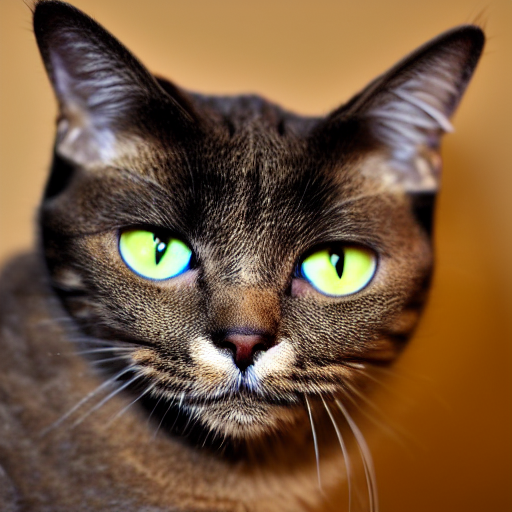

In [36]:
generate_with_embs(modified_output_embeddings)

0it [00:00, ?it/s]

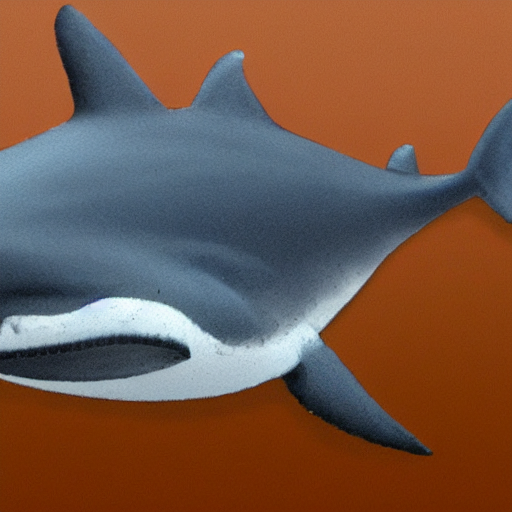

In [37]:
#embed two prompts
text_input1 = tokenizer(["A whale"], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input2 = tokenizer(["A shark"], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embedding1 = text_encoder(text_input1.input_ids.to(torch_device))[0]
  text_embedding2 = text_encoder(text_input2.input_ids.to(torch_device))[0]

#mix them together
mix_factor = 0.5
mixed_embeddings = (text_embedding1*mix_factor + \
                    text_embedding2 *(1-mix_factor))

#generate!
generate_with_embs(mixed_embeddings)

In [38]:
#UNet

#prepare scheduler
scheduler.set_timesteps(num_inference_steps)

#What is our timestep
t=scheduler.timesteps[0]
sigma = scheduler.sigmas[0]

#a noisy latent
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width //8),
    generator = generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

#text embedding
text_input = tokenizer(['A macaw'], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

#Run this through the unet to predict the noise residual
with torch.no_grad():
  noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings)["sample"]

latents.shape, noise_pred.shape #get pred in the same shape as the input

(torch.Size([1, 4, 64, 64]), torch.Size([1, 4, 64, 64]))

In [44]:
prompt = 'Oil painting of a fox in a top hat'
height = 512
width = 512
num_inference_steps = 50
guidance_scale = 8
generator = torch.manual_seed(32)
batch_size = 1

#make a folder to store results
!rm -rf steps/
!mkdir -p steps/

#text preparation
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length = max_length, return_tensors="pt"
)

with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

#scheduler preparation
scheduler.set_timesteps(num_inference_steps)

#latents preparation
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator = generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

#loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
  #expand the latents if we are doing classifier-free guidance to avoid doing two forward passes
  latent_model_input = torch.cat([latents] * 2)
  sigma = scheduler.sigmas[i]
  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  #perform guidance
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states = text_embeddings)["sample"]
  
  #performance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  #get the predicted x0:
  latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample #using scheduler diffusers 0.4 and above

  #compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

  #to PIL Images
  im_t0 = latents_to_pil(latents_x0)[0]
  im_next = latents_to_pil(latents)[0]

  #combine the two images and save for later viewing
  im = Image.new('RGB', (1024, 512))
  im.paste(im_next, (0,0))
  im.paste(im_t0, (512, 0))
  im.save(f'steps/{i:04}.jpeg')

0it [00:00, ?it/s]

In [45]:
#Make and show the progress video (change width to 1024 for full res)
!ffmpeg -v 1 -y -f image2 -framerate 12 -i steps/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open('out.mp4', 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
  <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [46]:
!pip install -q fastai

In [48]:
from fastai.callback.schedule import combined_cos

start sigma tensor(14.6146)
start est sigma tensor(14.5813, device='cuda:0')
14.591594696044922 999.0 tensor(0.0023, device='cuda:0') tensor(214.8251, device='cuda:0')
13.359740257263184 985.0 tensor(-0.0043, device='cuda:0') tensor(180.2430, device='cuda:0')
12.183627128601074 969.0 tensor(-0.0081, device='cuda:0') tensor(150.1252, device='cuda:0')
11.071771621704102 952.0 tensor(-0.0113, device='cuda:0') tensor(124.1416, device='cuda:0')
10.00268268585205 934.0 tensor(-0.0113, device='cuda:0') tensor(101.4164, device='cuda:0')
8.960197448730469 914.0 tensor(-0.0068, device='cuda:0') tensor(81.3917, device='cuda:0')
7.9341254234313965 891.0 tensor(-0.0020, device='cuda:0') tensor(63.8578, device='cuda:0')
6.920248985290527 864.0 tensor(0.0035, device='cuda:0') tensor(48.7744, device='cuda:0')
5.919950008392334 832.0 tensor(0.0180, device='cuda:0') tensor(35.4763, device='cuda:0')
4.936758041381836 793.0 tensor(0.0119, device='cuda:0') tensor(24.8128, device='cuda:0')
3.980244636535644

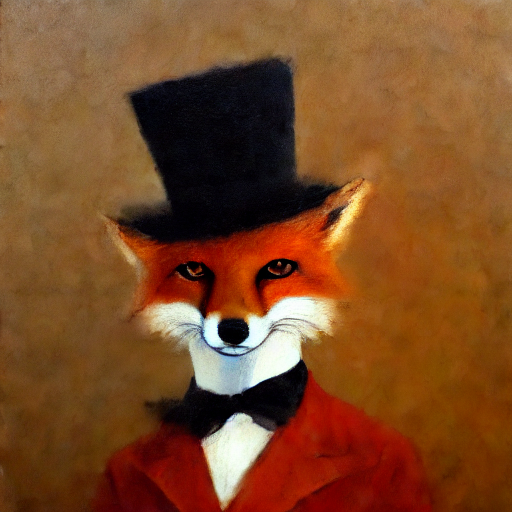

In [50]:
#LR schedule
lr_max = 0.15
mom = 0.7
div = 25.
div_final = 100
pct_start = 0.60
max_steps = 30
start_sigma = 14

lr_sched = combined_cos(pct_start, start_sigma*lr_max/div, lr_max, lr_max/div_final)
mom_sched = combined_cos(pct_start,mom/div, mom, mom/div_final)

prompt = ['Oil painting of a fox in a top hat']
height = 512
width = 512
guidance_scale = 7.5
generator = torch.manual_seed(32)
batch_size = 1

#text embeddings preparation
text_input = tokenizer(prompt, padding ="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"    
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

#scheduler preparation
scheduler.set_timesteps(1000)
start_sigma = scheduler.sigmas[0]
print('start sigma', start_sigma)

#function to go from sigma -> t based on scheduler to skip doing math
def t_from_sigma(sigma, sigma_min=0.002, sigma_max=14, rho=7, M=1000):
  for s, t in zip(scheduler.sigmas[1:], scheduler.timesteps):
    if s < sigma:
      return t
  return 1

#latents preparation
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator = generator,
)
latents = latents.to(torch_device)
latents = latents * start_sigma #need to scale to match k
print('start est sigma', (latents.var().detach()-1)**0.5)

latents.requires_grad = True
optim = torch.optim.SGD([latents], lr=lr_sched(0), momentum=mom_sched(0))
t=torch.tensor(999.0).to(torch_device) #starting t value

#loop
for i in range(max_steps):
  #expand the latents if doing classifer free guidance to avoid doing two forward passes
  latent_model_input = torch.cat([latents]*2)

  #estimate sigma from the latents
  sigma= (latents.var().detach()-0.7)**0.5 # the -0.7 assuming data is variance 0.7
  if torch.isnan(sigma):
    sigma = torch.tensor(0.2)
  
  t=t_from_sigma(sigma) #currently uses the schdule rather than doing the math
  latent_model_input = latent_model_input / ((sigma**2 + 1)** 0.5)

  #predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
  
  #update lr and mom in schedule
  for g in optim.param_groups:
    g['lr'] = lr_sched(i/max_steps)
    g['momentum'] = mom_sched(i/max_steps)

  #guidance performance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  #early stopping if noise pred is very small
  if(noise_pred.float() * sigma).var() < 0.1 or i == max_steps-1:
    latents = latents - sigma * noise_pred #predicted output
    print('stopping at step: ', i)
    break

  #noise_pred is basically the grad, so GD on this hsould find a minimum!
  latents.grad = noise_pred.float() * sigma # NB model ouput is unit variance needs to be scaled
  print(sigma.item(), t.item(), latents.grad.mean(), latents.grad.var())
  optim.step()
  optim.zero_grad()

latents_to_pil(latents)[0]

In [51]:
def blue_loss(images):
  #how far are the blue channel values to 0.9:
  error=torch.abs(images[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel
  return error

0it [00:00, ?it/s]

0 loss: 29.130176544189453
10 loss: 6.337490081787109
20 loss: 4.641983985900879
30 loss: 4.117583274841309
40 loss: 3.8918190002441406


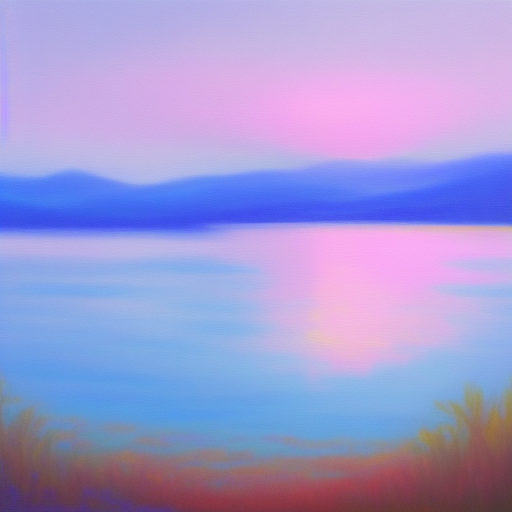

In [53]:
prompt = 'A lake at sunset (oil on canvas)'
height = 512 #default height of Stable Diffusion
width = 512 #default width of Stable Diffusion
num_inference_steps = 50 #number of denoising steps
guidance_scale = 8 #scale for classifier-gree guidance
generator = torch.manual_seed(32) #seed generator to create the initial latent noise
batch_size = 1
blue_loss_scale = 40

#text preparation
text_input = tokenizer([prompt], padding ="max_length", max_length = tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

#and the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding = "max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

#scheduler preparation
scheduler.set_timesteps(num_inference_steps)

#latents preparation
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

#loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
  #expand the latents
  latent_model_input = torch.cat([latents]*2)
  sigma = scheduler.sigmas[i]
  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  #predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states = text_embeddings)["sample"]

  #perform classifier free guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  #additional guidance
  latents = latents.detach().requires_grad_()

  #get the predicted x0
  latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

  #decode to image space
  denoised_images = vae.decode((1/0.18215) * latents_x0).sample / 2 + 0.5 #range(0, 1)

  #calculate loss
  loss = blue_loss(denoised_images) * blue_loss_scale
  if i%10==0:
    print(i, 'loss:', loss.item())

  #get gradient
  cond_grad = -torch.autograd.grad(loss, latents)[0]

  #modify the latents based on this gradient
  latents = latents.detach() + cond_grad * sigma**2

  #Now step with scheduler
  latents = scheduler.step(noise_pred, t, latents).prev_sample

latents_to_pil(latents)[0]